In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from datetime import timedelta

asset_class='Certificate of Deposit'

In [ ]:
# Main: identify low points (and plot the results)
if __name__ == "__main__":

    # Load the data
    running_balances = pd.read_pickle('running_balances.pkl')
    windows = pd.DataFrame()

    assets = ['Certificate of Deposit', 'Mutual Fund', 'Commercial Paper', 'Money Market', 'US Treasuries', 'US Agencies']

    for asset_class in assets:
        df = running_balances[
            (running_balances['TransactionClass'] == asset_class) &
            (running_balances['TransactionDate'] >= '2025-06-03') &
            (running_balances['TransactionDate'] <= '2025-12-31')

        ][['TransactionDate', 'Available']].rename(
            columns={'TransactionDate': 'Date', 'Available': 'Balance'}
        )
        # result = identify_low_points(df)
        result['Asset Class'] = asset_class
        windows = pd.concat([windows,result], ignore_index=True)

    pd.set_option('display.max_rows', None)

    print("Identified Time Intervals:")
    with pd.option_context('display.float_format', lambda x: f'{x/1e6:.2f}M',
                          'display.max_rows', None,
                          'display.max_columns', None,
                          'display.width', None):
        print(result.sort_values('StartDate', ascending=True))
        result.sort_values('StartDate', ascending=True)

Identified Time Intervals:
  LowPointDate  LowPointBalance  StartDate    EndDate  TimeSpanDays  \
0   2025-12-30            0.00M 2025-12-30 2025-12-31             2   

   Asset Class  
0  US Agencies  


In [ ]:
# Get the min and max date in the result df and count the number of days between them
min_date = result['StartDate'].min()
# max_date = result['EndDate'].max()
max_date = min_date + timedelta(days=120)  # Assuming a 6-month period from the min date
days_between = (max_date - min_date).days + 1  # +1 to include both start and end dates
print(f"Number of days: {days_between} days")

Number of days: 2 days


In [49]:
# Set display options to show all rows and format numbers as millions
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: f'{x/1e6:.2f}M')

# Display the full result DataFrame
result.sort_values('StartDate', ascending=True).drop(columns=['EndDate'])

,LowPointDate,LowPointBalance,StartDate,TimeSpanDays,Asset Class
0,2025-12-30,0.00M,2025-12-30,2,US Agencies


In [51]:
windows
windows.to_pickle('invest_windows.pkl')
len(windows)

6

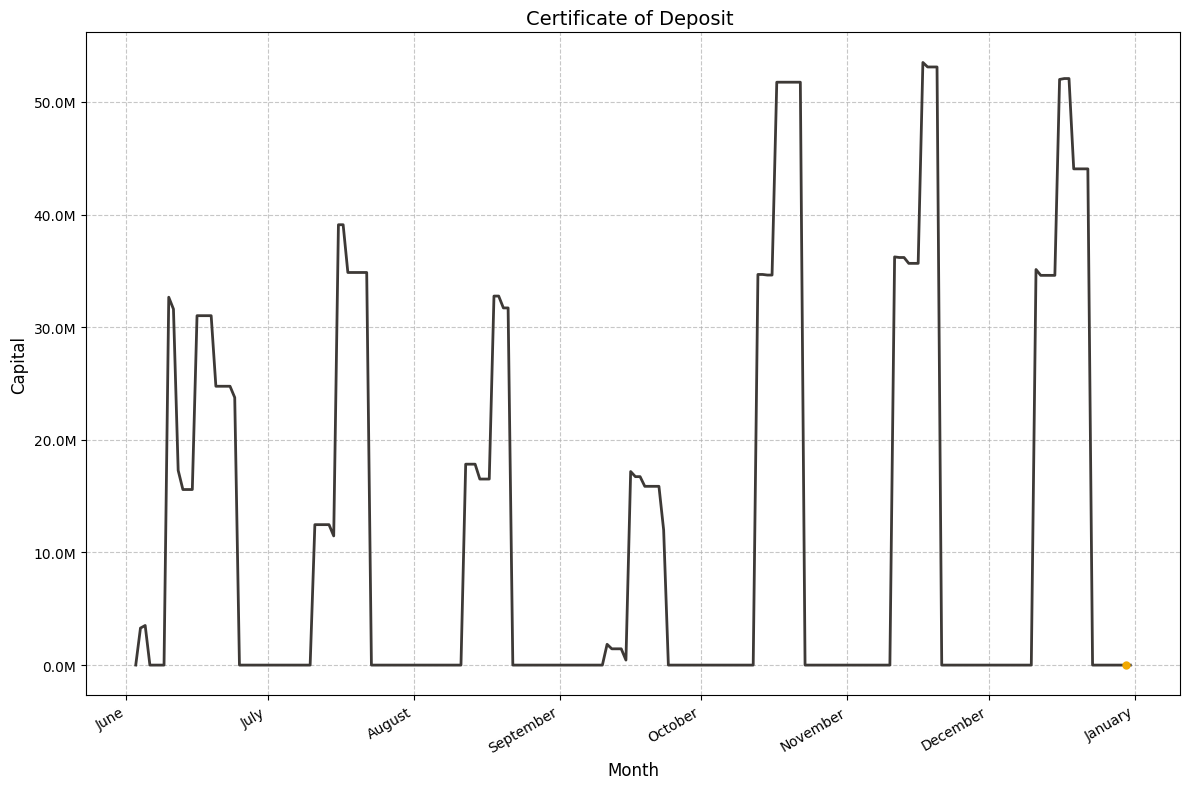

In [55]:
# Plot the balance with intervals
# asset_class = 'Commercial Paper'
asset_class='Certificate of Deposit'
# asset_class='Certificate of Deposit'
plot = plot_balance_with_intervals(df, result,asset_class)
plt.show()

In [ ]:
# This function identifies low points in a time series df and creates time intervals
def identify_low_points(df, asset_class ='Asset Class', min_days=2):
#     from those points to the max. date in the dataset. This represents the longest investment period.
    """
    Identifies time intervals from the latest date back to progressively earlier low points.
    Each interval starts at an identified low point and extends forward to the maximum date.
    When consecutive points have the same low balance, only the first occurrence is captured.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing at least 'Date' and 'Balance' columns
    min_days : int, default=2
        Minimum number of days for a valid time span

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the low points and their time spans
    """

    # Ensure Date column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'])

    # Sort df chronologically
    df = df.sort_values('Date')

    # Get the maximum date in the dataset (end of all intervals)
    max_date = df['Date'].max()
    min_date = df['Date'].min()

    # Find local minima (low points) in reverse chronological order
    dates = df['Date'].tolist()
    balances = df['Balance'].tolist()

    local_minima = []
    # Track unique balance values we've already seen to avoid duplicates
    seen_balances = set()

    for i in range(len(df) - 1, -1, -1):  # Iterate from end to start
        current_date = dates[i]
        current_balance = balances[i]

        # Skip the maximum date (we'll always end there)
        if current_date == max_date:
            continue

        # Check if this is a local minimum by looking at adjacent points
        is_local_min = True

        # Check if the current point is lower than all future points
        for j in range(i + 1, len(df)):
            if balances[j] < current_balance:
                is_local_min = False
                break

        if is_local_min and current_balance not in seen_balances:
            local_minima.append((current_date, current_balance))
            seen_balances.add(current_balance)

    # Sort local minima from latest to earliest
    local_minima.sort(key=lambda x: x[0], reverse=True)

    # Find the absolute minimum for the entire period
    absolute_min_idx = df['Balance'].idxmin()
    absolute_min_date = df.loc[absolute_min_idx, 'Date']
    absolute_min_balance = df.loc[absolute_min_idx, 'Balance']

    # Process local minima to create time intervals
    results = []

    # Add intervals from each low point to max_date
    for i, (low_date, low_balance) in enumerate(local_minima):
        # Start date is the low point
        start_date = low_date

        # End date is always the maximum date
        end_date = max_date

        # Calculate time span
        time_span = (end_date - start_date).days + 1  # +1 to include both start and end dates

        # Check if time span meets minimum requirement
        if time_span >= min_days:
            # Find the minimum balance in this time span
            span_min_balance = df[(df['Date'] >= start_date) &
                                 (df['Date'] <= end_date)]['Balance'].min()

            results.append({
                'LowPointDate': low_date,
                'LowPointBalance': low_balance,
                'StartDate': start_date,
                'EndDate': end_date,
                'TimeSpanDays': time_span #,
                # 'MinimumBalanceInSpan': span_min_balance
            })

    # Check if the absolute minimum is already in our results by balance value
    absolute_min_already_included = absolute_min_balance in [res['LowPointBalance'] for res in results]

    # Always add the full time interval (min_date to max_date)
    # containing the absolute minimum balance if not already captured
    if not absolute_min_already_included:
        full_span = (max_date - min_date).days + 1
        results.append({
            'LowPointDate': absolute_min_date,
            'LowPointBalance': absolute_min_balance,
            'StartDate': min_date,
            'EndDate': max_date,
            'TimeSpanDays': full_span #,
            # 'MinimumBalanceInSpan': absolute_min_balance
        })

    # Convert results to DataFrame and sort by time span (ascending)
    if results:
        result_df = pd.DataFrame(results)
        result_df = result_df.sort_values('TimeSpanDays')
        return result_df
    else:
        return pd.DataFrame(columns=['LowPointDate', 'LowPointBalance',
                                    'StartDate', 'EndDate', 'TimeSpanDays'])

In [ ]:
def plot_balance_with_intervals(df, intervals_df,asset_class='Asset Class'):
    """
    Plots the balance trend with highlighted intervals from low points to max date.

    Parameters:
    -----------
    df : pandas.DataFrame
        Original DataFrame with 'Date' and 'Balance' columns
    intervals_df : pandas.DataFrame
        DataFrame returned by identify_low_points function
    """
    plt.figure(figsize=(12, 8))

    # Plot balance trend
    # plt.plot(df['Date'], df['Balance'], label='Balance', linewidth=2, color="#3d3936",linestyle='solid')
    plt.plot(df['Date'], df[asset_class], label=asset_class, linewidth=2, color="#3d3936",linestyle='solid')
    # Format y-axis in millions
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    # Sorted intervals from shortest to longest
    sorted_intervals = intervals_df.sort_values('TimeSpanDays')

    # # Plot each interval with progressively lighter opacity for longer intervals
    for i, row in enumerate(sorted_intervals.itertuples()):
          # Mark the low point
          plt.plot(row.LowPointDate, row.LowPointBalance, 'o', markersize=5, color="#f2a900")

    # Format the plot
    plt.title(asset_class + ' ', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Capital', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Format x-axis date labels
    plt.gcf().autofmt_xdate()
    date_format = mdates.DateFormatter('%B')
    plt.gca().xaxis.set_major_formatter(date_format)

    plt.tight_layout()
    return plt